<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Outputs a file with code block to copy paste into reconstruct_3d script, for one large template with all barcodes. Can process multiple slices at a time.

In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown [See Instructions](https://docs.google.com/document/d/1XAVQ2KHBn9OPUEbf9dRE8Kuds44gkQqYAzBNehx_rec/edit?tab=t.0#bookmark=id.4pm64yj4s5n8) for instructions on how to get these values:
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')


# um_per_px = 5

# Units: px
fluorescent_csv_path = "coregister-xy/example_data/fluorescent_image_points.csv" # @param {type:"string"}

# Units: mm
template_csv_path = "coregister-xy/example_data/template_points.csv" # @param {type:"string"}

# This is the file where the plane_input.append() lines to copy paste into reconstruct_3d.ipynb will be written to
# Change as desired
output_planes_description = "planes_description.txt"# @param {type:"string"}

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# @title Environment Setup
!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import plotly.graph_objects as go

%cd ..

fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [3]:
# @title Load data from CSV
def load_data_from_csv(csv_path):
  df = pd.read_csv(fluorescent_csv_path)
  df_template = pd.read_csv(template_csv_path)

  fluorescent_points_uvz = {}
  fluorescent_image_paths = {}
  n_slices = df['Slice'].max()
  slice_start = df['Slice'].min()

  template_points_xyz_mm_all_planes = []
  fluorescent_points_uv_pix_all_planes = []
  slice_idx = []

  for idx in range(slice_start, n_slices + 1):
      fluorescent_points_uvz[idx] = [
          (row['X'], row['Y'], row['z_um']) for _, row in df[df['Slice'] == idx].iterrows()
      ]

  for idx, row in df[df['fluorescent_image_path'].notna()].iterrows():
      fluorescent_image_paths[row['Slice']] = row['fluorescent_image_path']

  template_points_xy_mm = [(row['X'], row['Y']) for _, row in df_template.iterrows()]

  for idx in fluorescent_points_uvz:
    z = np.array(fluorescent_points_uvz[idx])[:,2] / 1000
    fluorescent_points_uv_pix = np.array(fluorescent_points_uvz[idx])[:,:2]
    template_points_xyz_mm = np.hstack([np.array(template_points_xy_mm), z.reshape(-1, 1)])
    template_points_xyz_mm_all_planes.append(template_points_xyz_mm)
    fluorescent_points_uv_pix_all_planes.append(fluorescent_points_uv_pix)
    slice_idx.append(idx)

  return fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes, fluorescent_image_paths, slice_idx

# Load data
fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes, fluorescent_image_paths, slice_idx = load_data_from_csv(fluorescent_csv_path)

In [4]:
# @title Compute mapping between fluorescent and template points
fps = []
in_plane_err_mm_per_plane = []
out_plane_err_mm_per_plane = []
in_plane_err_mm_per_point = []
out_plane_err_mm_per_point = []

with open(output_planes_description, "w") as outf:
  for (idx, fluorescent_points_uv_pix, template_points_xyz_mm) in (zip(slice_idx, fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes)):

    fp = FitPlane.from_template_centers(fluorescent_points_uv_pix, template_points_xyz_mm, print_inputs = False)
    fps.append(fp)

    # In plane and out of plane error
    # Individual points
    in_plane_err, out_plane_err = fp.get_template_center_positions_distance_metrics(fluorescent_points_uv_pix, template_points_xyz_mm, False)
    in_plane_err_mm_per_point.append(in_plane_err)
    out_plane_err_mm_per_point.append(out_plane_err)

    # Mean over slice
    in_plane_err, out_plane_err = fp.get_template_center_positions_distance_metrics(fluorescent_points_uv_pix, template_points_xyz_mm, True)
    in_plane_err_mm_per_plane.append(in_plane_err)
    out_plane_err_mm_per_plane.append(out_plane_err)

    print("")
    print(f'Data for slice {idx}:')
    print('---------------')
    print(f"Average in-plane mapping error: {in_plane_err*1000:.2f} um")
    print(f"Average out-of-plane mapping error: {out_plane_err*1000:.2f} um")
    print('---------------')
    print("fp = FitPlane.from_json('" + fp.to_json() + "')")
    print(f"\nplane_inputs.append({{\n\"uv_pix\": {fluorescent_points_uv_pix.tolist()},\n\"xyz_mm\": {template_points_xyz_mm.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")
    print()
    # Write to single output file
    outf.write(f"\nplane_inputs.append({{\n\"uv_pix\": {fluorescent_points_uv_pix.tolist()},\n\"xyz_mm\": {template_points_xyz_mm.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")

outf.close()
print(f"See output file {output_planes_description} for plane_input lines to copy into the reconstruct_3d.ipynb script!")


Data for slice 1:
---------------
Average in-plane mapping error: 3.23 um
Average out-of-plane mapping error: 0.00 um
---------------
fp = FitPlane.from_json('{"u": [0.0011416598899054863, -0.00025480858765866644, -3.947921138740263e-18], "v": [0.00024464918873106723, 0.0011815149343924036, 1.1968748954140742e-18], "h": [-0.9705803366672346, -0.05476643176799694, 0.02400000000000012]}')

plane_inputs.append({
"uv_pix": [[1927, 767], [1874, 991], [2098, 847], [2588, 1759], [2536, 1976], [2764, 1835]],
"xyz_mm": [[1.41331, 0.36551, 0.024], [1.41237, 0.63636, 0.024], [1.63543, 0.40769, 0.024], [2.41143, 1.36551, 0.024], [2.40956, 1.63355, 0.024], [2.63449, 1.40862, 0.024]],
"image_file_path": "/coregister-xy/data/r2s1s4.tif"
})


Data for slice 2:
---------------
Average in-plane mapping error: 2.68 um
Average out-of-plane mapping error: 0.11 um
---------------
fp = FitPlane.from_json('{"u": [0.0011750234729282821, -6.519486492980627e-05, 1.2142669027490763e-06], "v": [5.8995142394064205

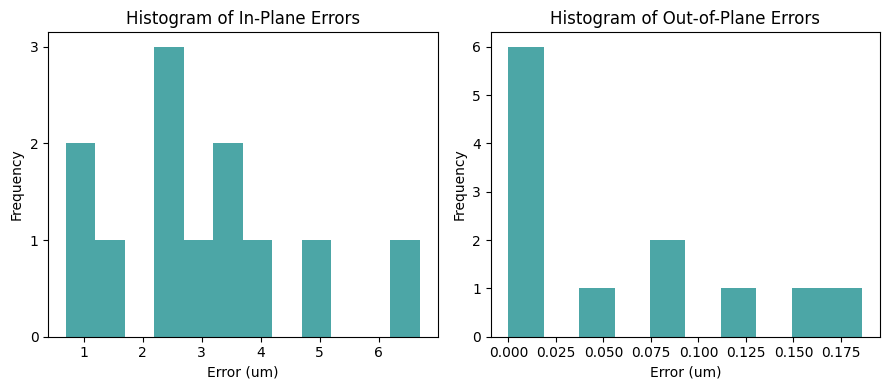

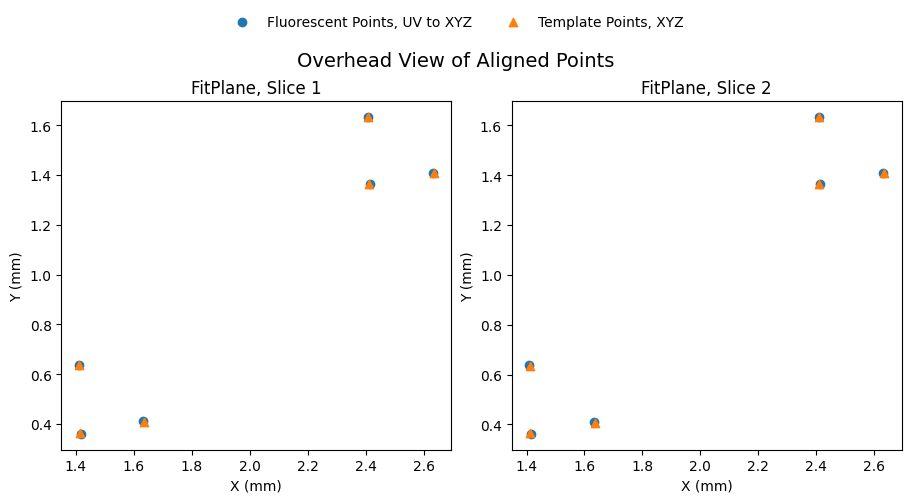

In [25]:
# @title Plot average error and overhead view of aligned points

def plot_error_histogram(in_plane_err_mm_per_point, out_plane_err_mm_per_point):
  # Flatten lists
  in_plane_err_values = np.hstack(in_plane_err_mm_per_point) * 1000  # Convert to um
  out_plane_err_values = np.hstack(out_plane_err_mm_per_point) * 1000

  plt.figure(figsize=(9, 4))

  # Set in-plane error bin width
  in_bin_width = 0.5
  bins_in_plane = np.arange(min(in_plane_err_values), max(in_plane_err_values) + in_bin_width, in_bin_width)

  # Subplot 1: In-Plane Error Histogram
  plt.subplot(1, 2, 1)
  counts, bins, patches = plt.hist(in_plane_err_values, bins=bins_in_plane, color='teal', alpha=0.7)
  plt.xlabel('Error (um)')
  plt.ylabel('Frequency')
  plt.title('Histogram of In-Plane Errors')
  plt.yticks(np.arange(0, max(counts) + 1, step=1))

  # Subplot 2: Out-of-Plane Error Histogram
  plt.subplot(1, 2, 2)
  counts, bins, patches = plt.hist(out_plane_err_values, bins=10, color='teal', alpha=0.7)
  plt.xlabel('Error (um)')
  plt.ylabel('Frequency')
  plt.title('Histogram of Out-of-Plane Errors')
  plt.yticks(np.arange(0, max(counts) + 1, step=1))  # Set y-axis to integers

  plt.tight_layout()
  plt.show()

def plot_overhead_view(slice_idx, template_points_xyz_mm_all_planes, fluorescent_points_uv_pix_all_planes, fps):
    num_slices = len(slice_idx)
    cols = min(3, num_slices)  # Display in up to 3 columns
    rows = (num_slices // cols) + (num_slices % cols > 0)  # number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # Flatten axes in case of single row/column

    # Store plot handles for a common legend
    handles, labels = [], []

    for idx, (slice_num, ax) in enumerate(zip(slice_idx, axes)):
        template_points_xyz_mm = template_points_xyz_mm_all_planes[idx]
        fluorescent_points_uv_pix = fluorescent_points_uv_pix_all_planes[idx]
        fp = fps[idx]

        # Convert UV points to XYZ
        a = np.array([fp.get_xyz_from_uv(t) for t in fluorescent_points_uv_pix])

        # Plot points
        h1 = ax.scatter(a[:,0], a[:,1], label="Fluorescent Points, UV to XYZ")
        h2 = ax.scatter(template_points_xyz_mm[:, 0], template_points_xyz_mm[:, 1],
                        label="Template Points, XYZ", marker='^')

        # Collect handles for global legend (only once)
        if idx == 0:
            handles.extend([h1, h2])
            labels.extend(["Fluorescent Points, UV to XYZ", "Template Points, XYZ"])

        ax.set_xlabel("X (mm)")
        ax.set_ylabel("Y (mm)")
        ax.set_title(f"FitPlane, Slice {slice_num}")

    # Hide unused subplots if slices < total grid size
    for ax in axes[num_slices:]:
        ax.axis("off")

    # Add one common legend outside the subplots
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, frameon=False)

    plt.suptitle("Overhead View of Aligned Points", fontsize=14)
    plt.show()

plot_error_histogram(in_plane_err_mm_per_point, out_plane_err_mm_per_point)
plot_overhead_view(slice_idx, template_points_xyz_mm_all_planes, fluorescent_points_uv_pix_all_planes, fps)

In [6]:
# @title Plot all best fit planes in 3D

def plot_multiple_planes(planes_points):
    """Plots multiple best-fit planes from given sets of 3D points in an interactive plot."""

    fig = go.Figure()
    colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds']
    colors_points = ['blue', 'brown', 'ForestGreen', 'purple', 'burgundy']

    for idx, points in enumerate(planes_points):
        # Compute best-fit plane
        centroid = np.mean(points, axis=0)
        centered_points = points - centroid
        _, _, vh = np.linalg.svd(centered_points)
        normal = vh[-1]

        # Ensure the normal is pointing upwards (positive Z-component)
        if normal[2] < 0:
            normal = -normal

        A, B, C = normal
        D = -np.dot(normal, centroid)

        # Define grid for plane
        xlim, ylim = np.ptp(points[:, 0]), np.ptp(points[:, 1])
        xx, yy = np.meshgrid(
            np.linspace(np.min(points[:, 0])-0.2*xlim, np.max(points[:, 0])+0.2*xlim, 20),
            np.linspace(np.min(points[:, 1])-0.2*ylim, np.max(points[:, 1])+0.2*ylim, 20)
        )
        zz = (-A * xx - B * yy - D) / C  # Solve for z in Ax + By + Cz + D = 0

        # Plot the plane
        fig.add_trace(go.Surface(
            x=xx, y=yy, z=zz,
            colorscale=colors[idx % len(colors)],  # Cycle through colors
            opacity=0.5,
            showscale=False,
            name=f'Plane {idx+1}'
        ))

        # Plot the points
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors_points[idx % len(colors_points)], opacity=0.8),
            name=f'Slice {idx+1}'
        ))

    # Set axis labels and improve visibility
    fig.update_layout(
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='auto'
        ),
        title="Multiple Best-Fit Planes with 3D Points (Interactive)",
    )

    # Show interactive plot
    fig.show()

plot_multiple_planes(template_points_xyz_mm_all_planes)